# Hourly Time Series Forecasting using XGBoost



In [195]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from prophet import Prophet


# Data


In [196]:
pjme = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [197]:
pjme

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


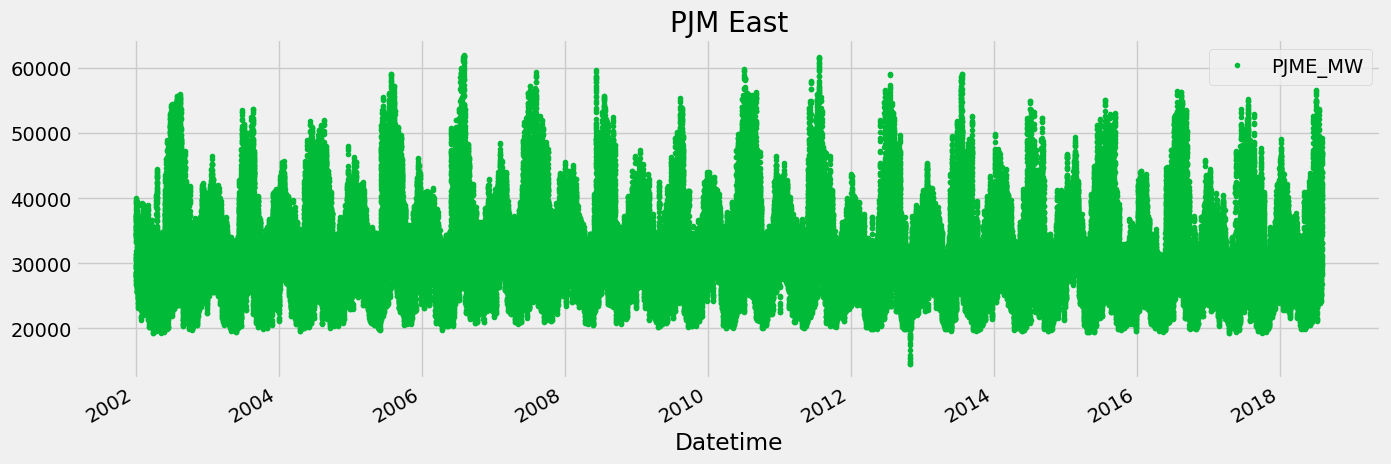

In [198]:
_ = pjme.plot(style='.', figsize=(15,5), color="#00BA38", title='PJM East')

C:\Users\M.M\AppData\Local\Temp\ipykernel_4100\3111970797.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pjme_week = pjme.loc[(pjme.index >= '2017-01-01') & (pjme.index <= '2017-01-08')].resample('H').mean().ffill()


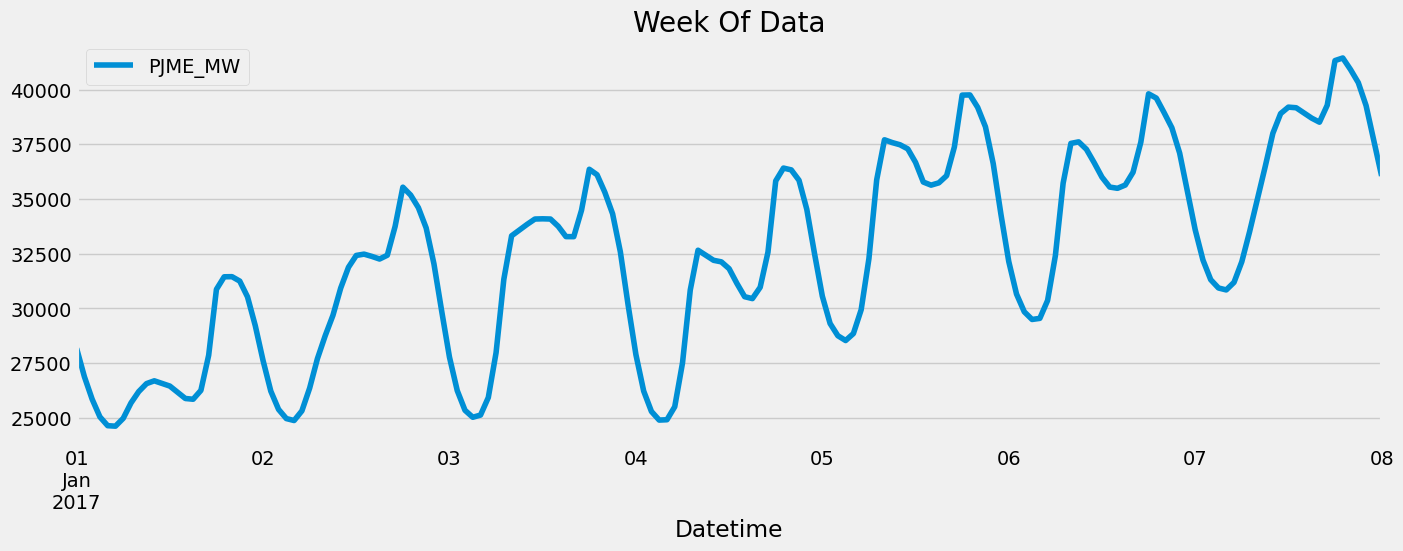

In [199]:
import pandas as pd
import matplotlib.pyplot as plt

# Resample to hourly data (assuming hourly data) and forward fill to connect valid points
pjme_week = pjme.loc[(pjme.index >= '2017-01-01') & (pjme.index <= '2017-01-08')].resample('H').mean().ffill()

pjme_week.plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [200]:
import holidays

def create_features(df, label='PJME_MW', features_only = False, lags=[1, 24], rolling_windows=[24, 168]):
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['weekday'] = df['date'].dt.day_name()

    # Add US holiday feature
    us_holidays = holidays.US()
    df['holiday'] = df['date'].dt.date.isin(us_holidays).astype(int)

    # Add lag features
    if True:#label
        for lag in lags:
            df[f'lag_{lag}'] = df[label].shift(lag)

        # Add rolling mean features
        for window in rolling_windows:
            df[f'rolling_mean_{window}'] = df[label].shift(1).rolling(window=window).mean()

    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])
    # List all features to return (dynamically adds lag and rolling columns)
    base_features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
                     'dayofyear', 'dayofmonth', 'weekofyear', 'holiday','weekday', 'season']

    lag_features = [f'lag_{lag}' for lag in lags] if label else []
    roll_features = [f'rolling_mean_{w}' for w in rolling_windows] if label else []
    df['weekday'] = df['weekday'].astype('category')
    df['season'] = df['season'].astype('category')
    feature_columns = base_features + lag_features + roll_features
    all_feature_columns = base_features + lag_features + roll_features
    print(f"Feature columns: {feature_columns}")
    if features_only == False:
        # df = df.dropna()  # Drop rows with NaNs caused by shifting/rolling
        X = df[feature_columns]
        y = df[label]
        return X, y
    else:
        return df
    
pjme_features = create_features(pjme, features_only=True)


Feature columns: ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'holiday', 'weekday', 'season', 'lag_1', 'lag_24', 'rolling_mean_24', 'rolling_mean_168']


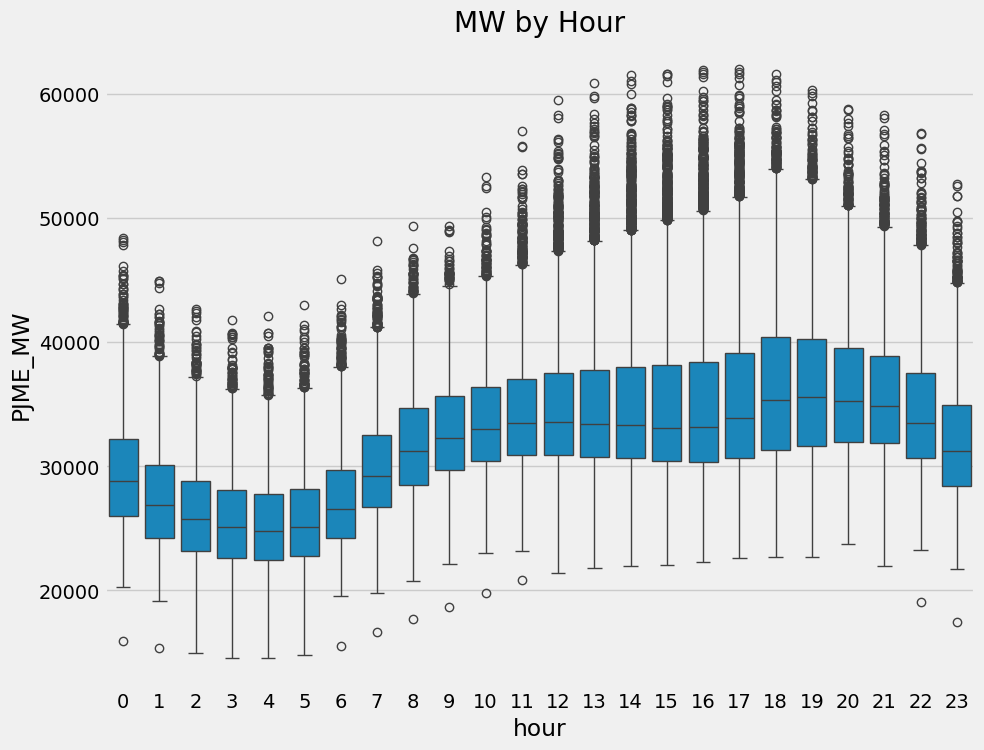

In [201]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=pjme_features, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

C:\Users\M.M\AppData\Local\Temp\ipykernel_4100\4271593030.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pjme_features, x='month', y='PJME_MW', palette='Blues')


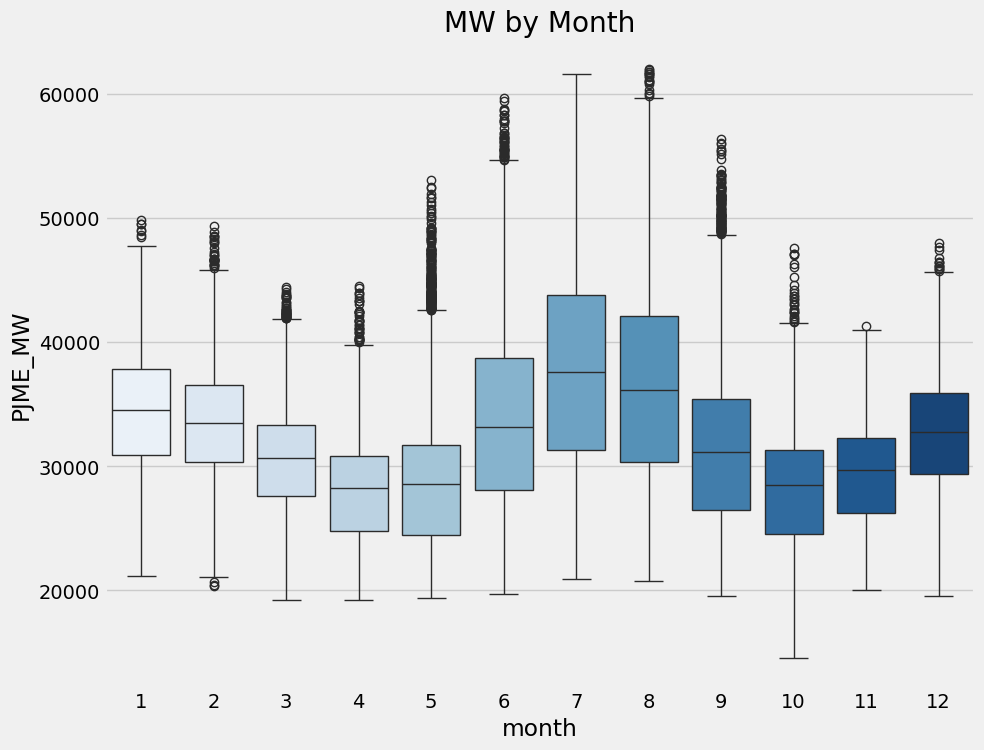

In [202]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=pjme_features, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

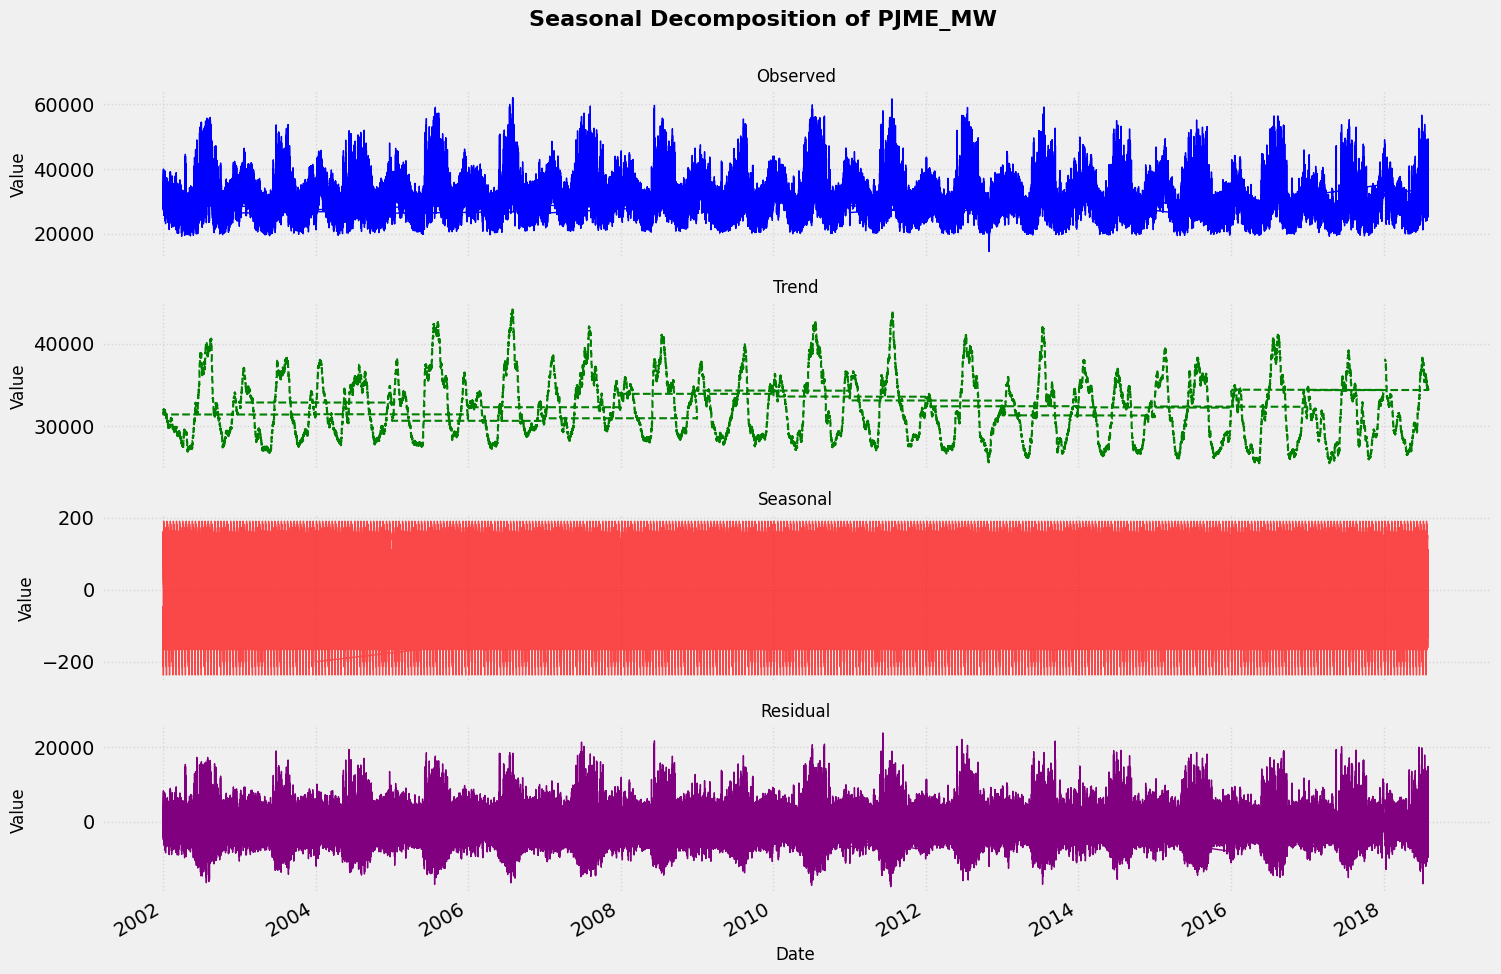

In [203]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with a datetime index and a column to decompose (e.g., 'PJME_MW')
result = seasonal_decompose(pjme_features['PJME_MW'], period=365)

# Create a figure with 4 subplots (stacked vertically)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

# Plot each component in its own subplot with customization
result.observed.plot(ax=ax1, color='blue', linewidth=1)
ax1.set_title('Observed', fontsize=12)
ax1.grid(True, linestyle=':', alpha=0.7)

result.trend.plot(ax=ax2, color='green', linestyle='--', linewidth=1.5)
ax2.set_title('Trend', fontsize=12)
ax2.grid(True, linestyle=':', alpha=0.7)

result.seasonal.plot(ax=ax3, color='red', alpha=0.7, linewidth=1)
ax3.set_title('Seasonal', fontsize=12)
ax3.grid(True, linestyle=':', alpha=0.7)

result.resid.plot(ax=ax4, color='purple', linewidth=1)
ax4.set_title('Residual', fontsize=12)
ax4.grid(True, linestyle=':', alpha=0.7)

# Customize overall title and labels
fig.suptitle('Seasonal Decomposition of PJME_MW', fontsize=16, fontweight='bold')
fig.tight_layout()
fig.subplots_adjust(top=0.9)  # Adjust top spacing for the main title

# Set x-label for the bottom subplot
ax4.set_xlabel('Date', fontsize=12)

# Optionally set y-labels for each subplot
ax1.set_ylabel('Value', fontsize=12)
ax2.set_ylabel('Value', fontsize=12)
ax3.set_ylabel('Value', fontsize=12)
ax4.set_ylabel('Value', fontsize=12)

# Show the plot
plt.show()

# Train/Test Split
Cut off the data after 2015 to use as our validation set.

In [204]:
# Create features for the entire dataset first
X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)
# Split the data into training and test sets after feature creation
split_date = '01-Jan-2015'

# Create training and testing datasets based on the split date
X_train = X[X.index <= split_date]
y_train = y[X.index <= split_date]

X_test = X[X.index > split_date]
y_test = y[X.index > split_date]


Feature columns: ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'holiday', 'weekday', 'season', 'lag_1', 'lag_24', 'rolling_mean_24', 'rolling_mean_168']


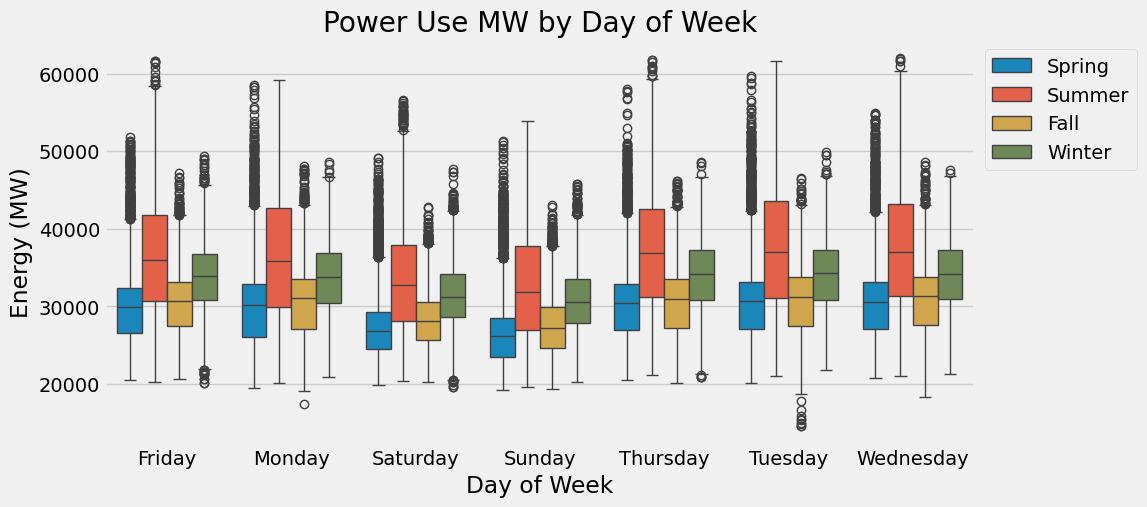

In [205]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [206]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()

# pjme_train = create_features(pjme)

pjme_test = pjme.loc[pjme.index > split_date].copy()



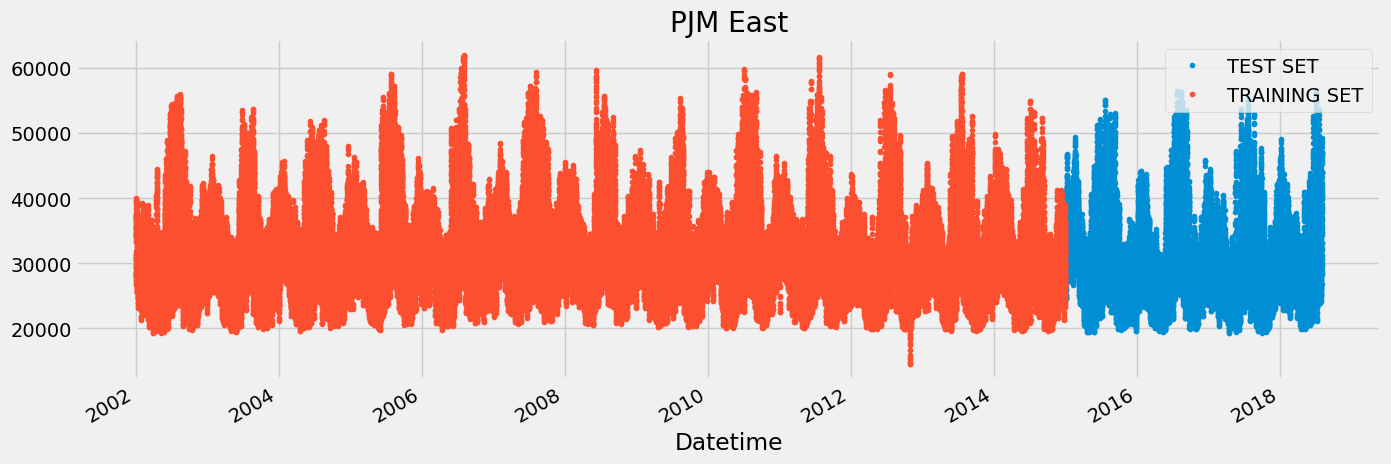

In [207]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

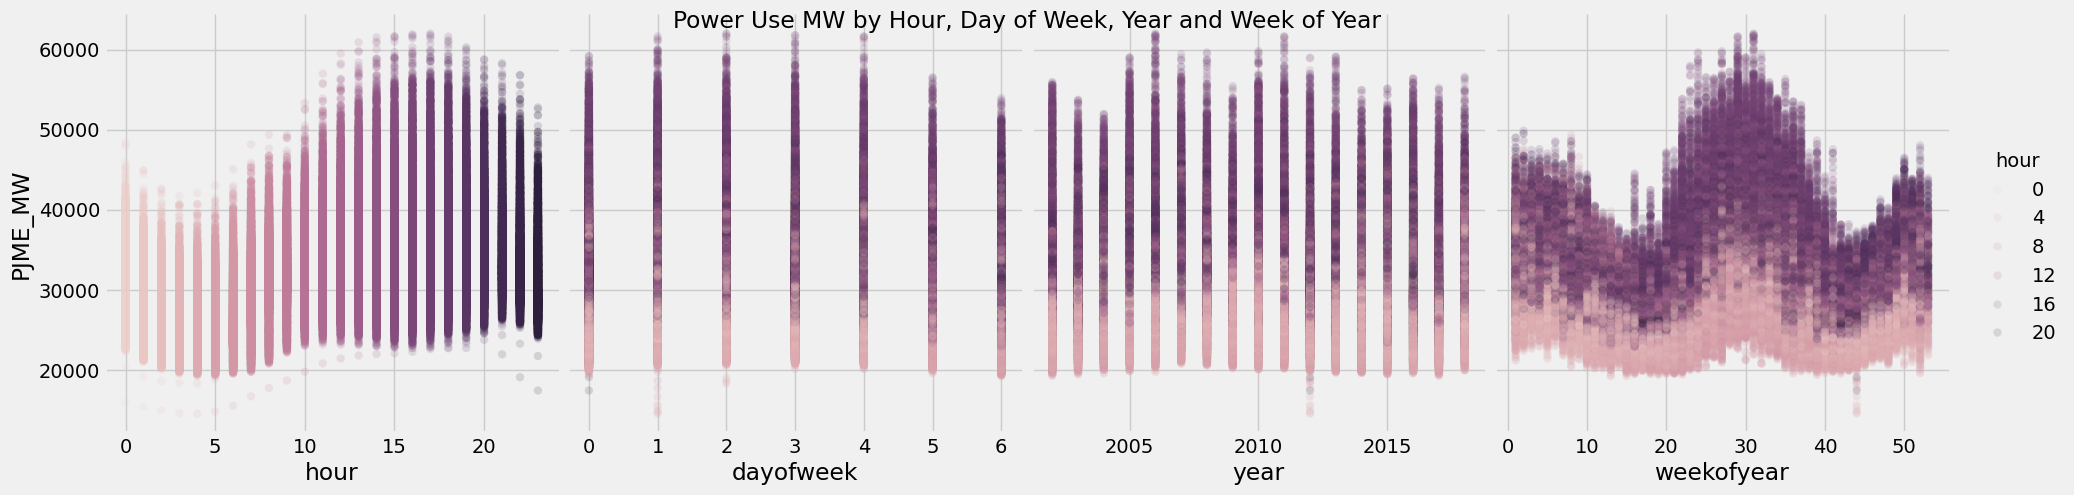

In [208]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

# Create Time Series Features

## Create XGBoost Model

In [209]:
reg = xgb.XGBRegressor(n_estimators=100, enable_categorical=True)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

### Feature Importances


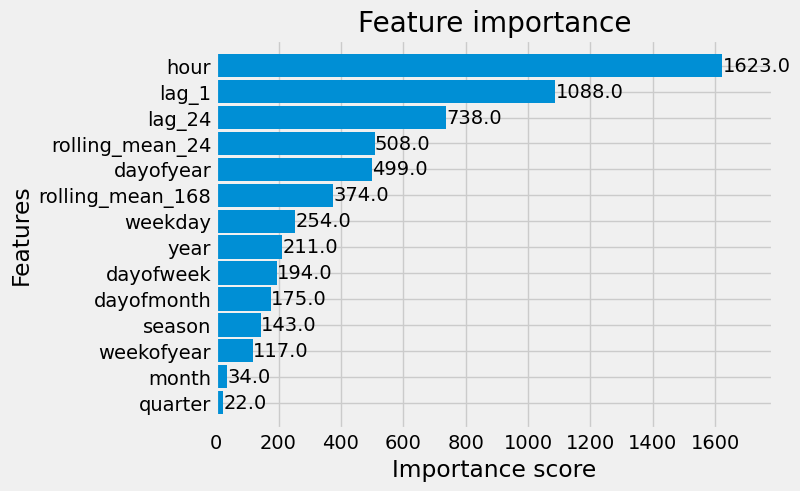

In [210]:
_ = plot_importance(reg, height=0.9)

## Forecast on Test Set

In [211]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_train,pjme_test], sort=False)

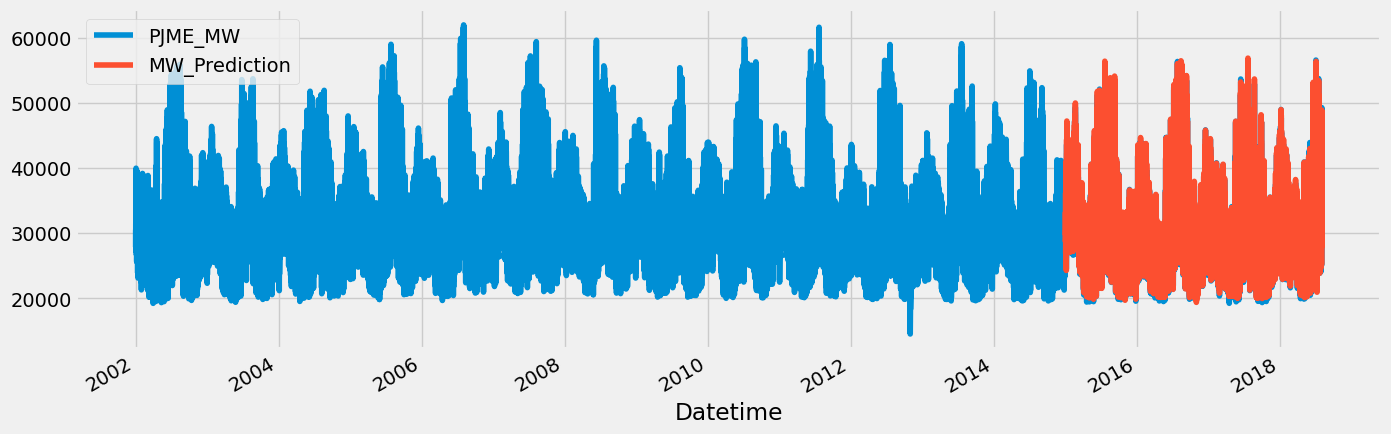

In [212]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

## Look at first month of predictions

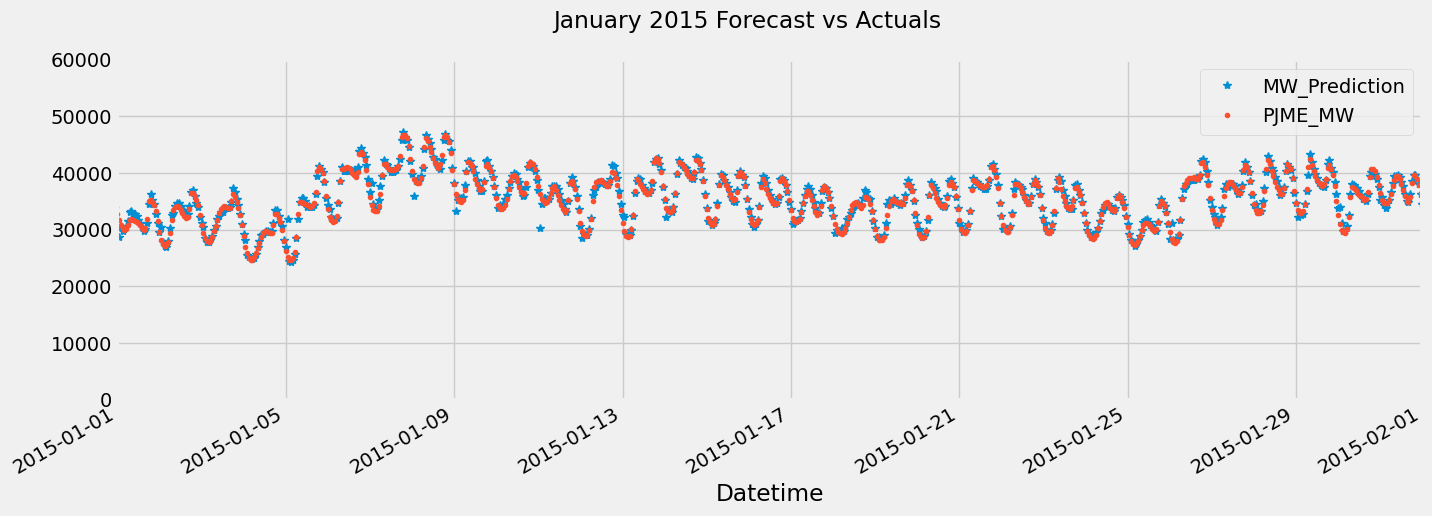

In [213]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['*','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

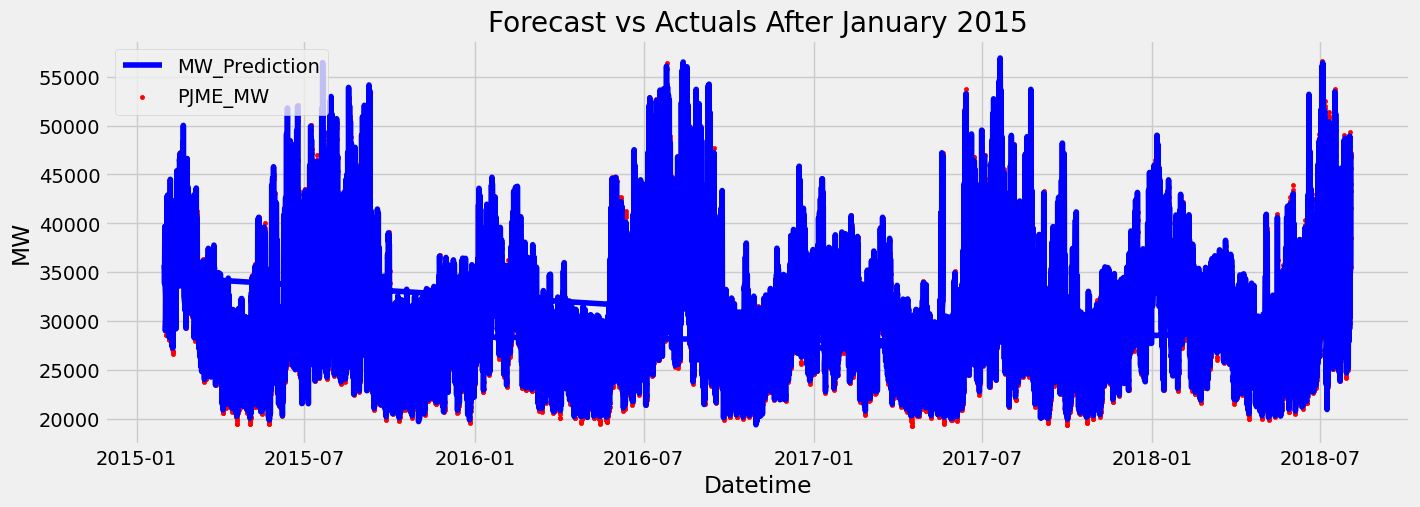

In [214]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter the DataFrame to include only data after January 2015
pjme_filtered = pjme_all[pjme_all.index > '2015-01-31']
# Create figure and axis with specified size
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
# Plotting the filtered data
plt.plot(pjme_filtered.index, pjme_filtered['MW_Prediction'], label='MW_Prediction', color='blue')  # Line for predictions
plt.scatter(pjme_filtered.index, pjme_filtered['PJME_MW'], label='PJME_MW', color='red', marker='.')  # Dots for actuals
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.title('Forecast vs Actuals After January 2015')  # Updated title to reflect the new range
plt.legend()
plt.show()

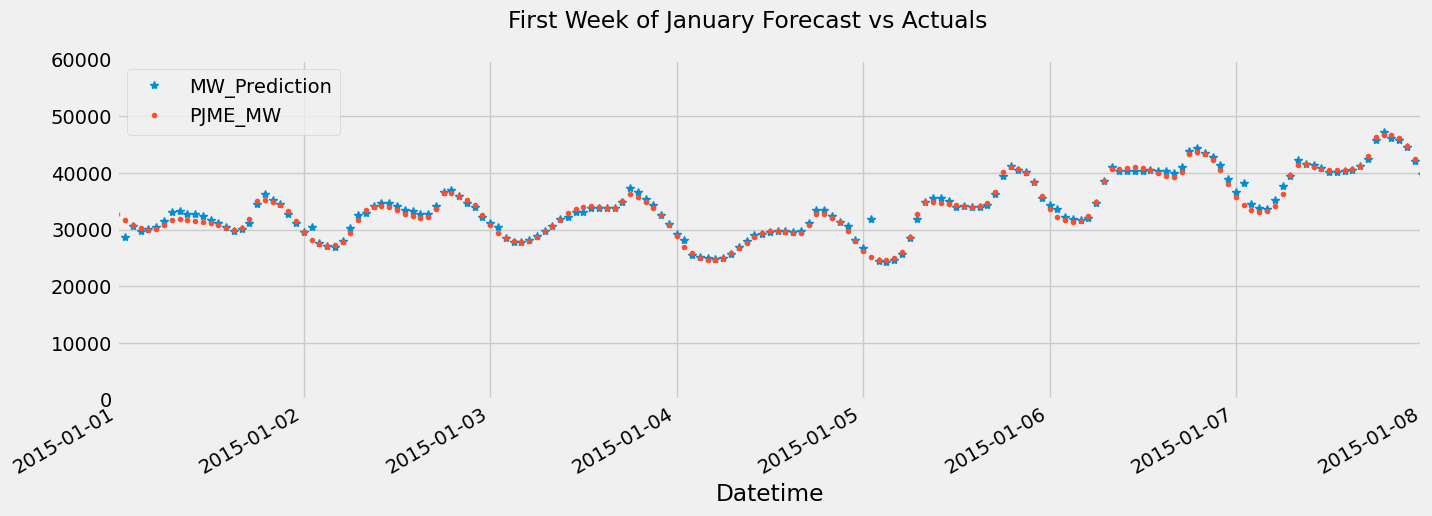

In [215]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['*','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

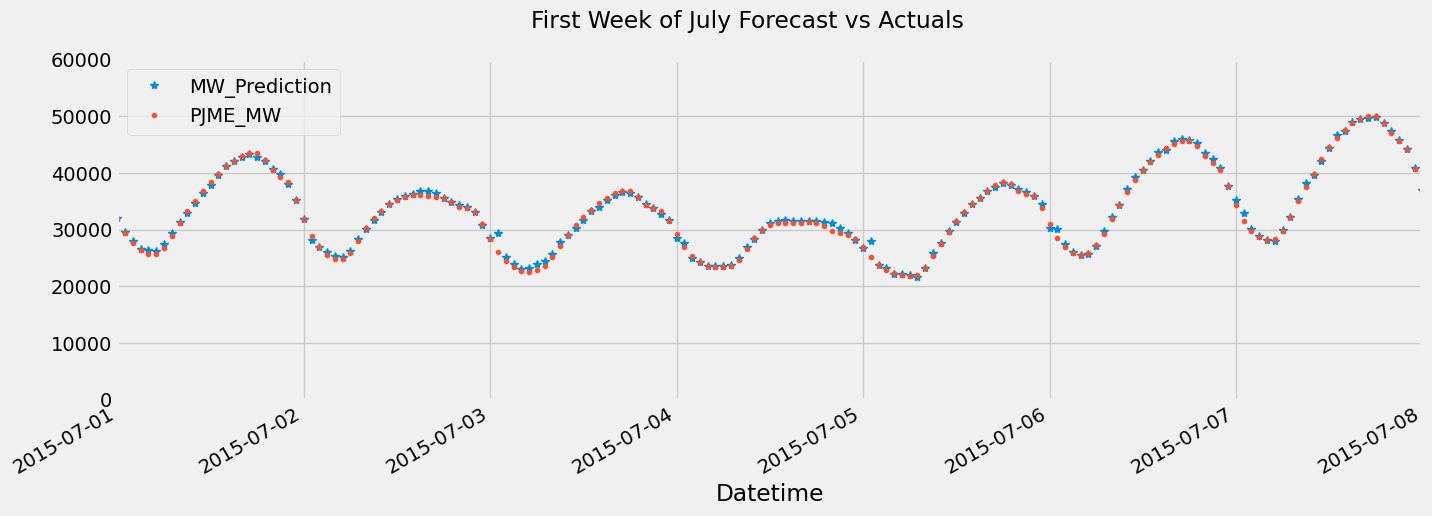

In [216]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['*','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

In [217]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

426548.08529588586

In [218]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

427.68584413964345

I like using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are.
MAPE isn't included in sklearn so we need to use a custom function.

In [219]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [220]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

np.float64(1.409072193958636)

## Look at Worst and Best Predicted Days

In [221]:
missing_cols = [col for col in X_test.columns if col not in pjme_test.columns]
pjme_test = pjme_test.copy()  # To avoid modifying the original y
for col in missing_cols:
    pjme_test[col] = X_test[col]


In [222]:
print(pjme_test.dtypes)

PJME_MW              float64
MW_Prediction        float32
hour                   int32
dayofweek              int32
quarter                int32
month                  int32
year                   int32
dayofyear              int32
dayofmonth             int32
weekofyear            UInt32
holiday                int64
weekday             category
season              category
lag_1                float64
lag_24               float64
rolling_mean_24      float64
rolling_mean_168     float64
dtype: object


In [223]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year', 'month', 'dayofmonth']).mean(numeric_only=True)[['PJME_MW', 'MW_Prediction', 'error', 'abs_error']]

In [224]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 12    25          24466.083333   25803.224609 -1337.141520  1370.448812
     2     14          36800.625000   37602.355469  -801.732259   819.783366
2017 3     9           27496.791667   28244.646484  -747.853516   779.108236
2016 3     24          26390.000000   27134.257812  -744.259033   760.863525
2017 9     8           27053.208333   27784.345703  -731.137207   798.256022
     4     5           26382.083333   27090.072266  -707.989746   707.989746
     5     4           25993.375000   26700.482422  -707.105794   710.814453
     2     25          24344.458333   25022.328125  -677.870443   680.173177
           8           28523.833333   29180.921875  -657.088623   675.107178
           20          27070.583333   27725.583984  -654.999919   781.306722

In [225]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 12    25          24466.083333   25803.224609 -1337.141520  1370.448812
2018 1     5           44197.791667   43178.664062  1019.126465  1037.449707
2015 2     20          44694.041667   44776.500000   -82.456217  1005.042480
     9     10          36586.541667   36759.875000  -173.332275   962.965902
2018 1     1           40191.041667   39929.394531   261.646077   954.073486
           3           40852.750000   40151.296875   701.452148   944.828776
2015 2     21          40918.666667   40510.812500   407.853923   899.737061
2017 9     24          32246.708333   32463.726562  -217.017090   868.124512
2018 1     7           42159.708333   41958.386719   201.323242   856.939128
2015 2     16          43949.500000   43439.152344   510.345540   854.998535

In [226]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 5     2           26955.125000   27061.388672 -106.264160  146.111979
     3     20          27989.416667   28053.031250  -63.614827  169.907633
2017 10    15          25363.250000   25426.390625  -63.141520  170.861735
2016 10    8           25183.333333   25257.867188  -74.533122  175.265055
2017 6     5           29205.416667   29332.978516 -127.562500  175.880208
2016 10    27          28611.166667   28719.632812 -108.465332  186.268066
2017 5     13          24752.333333   24922.568359 -170.235189  195.300293
     8     12          31822.666667   31966.677734 -144.010254  196.555827
2016 10    4           27400.208333   27550.095703 -149.887451  197.340088
2018 5     17          28035.208333   28159.330078 -124.123617  197.411214

## Plotting some best/worst predicted days

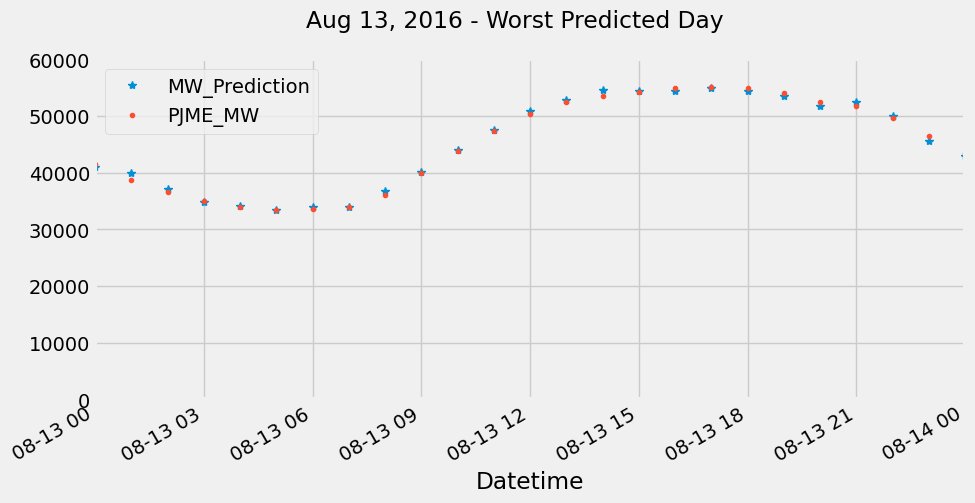

In [227]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['*','.'])


plt.style.use('fivethirtyeight')

ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

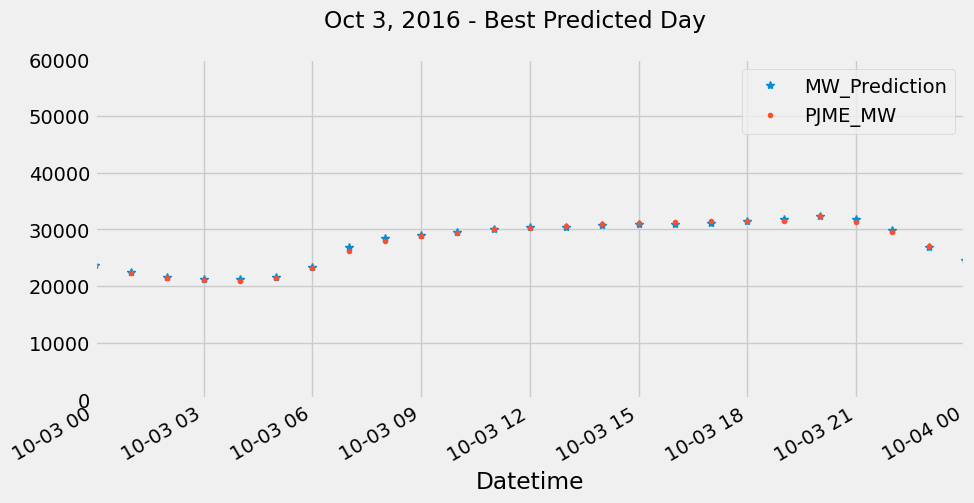

In [228]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['*','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

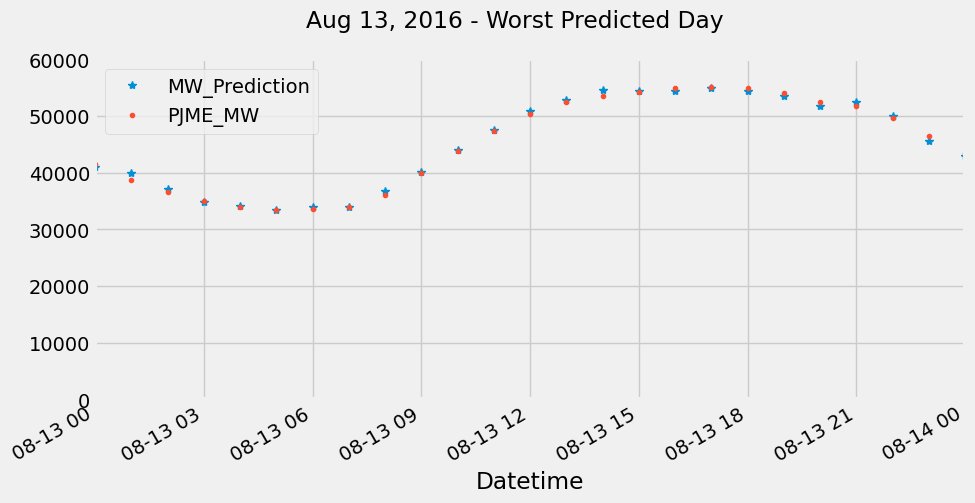

In [229]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['*','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

# Create Time Series Features

## Create Prophet Model

In [230]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'}).head()
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))

11:37:38 - cmdstanpy - INFO - Chain [1] start processing
11:38:49 - cmdstanpy - INFO - Chain [1] done processing


### Feature Importances


## Forecast on Test Set

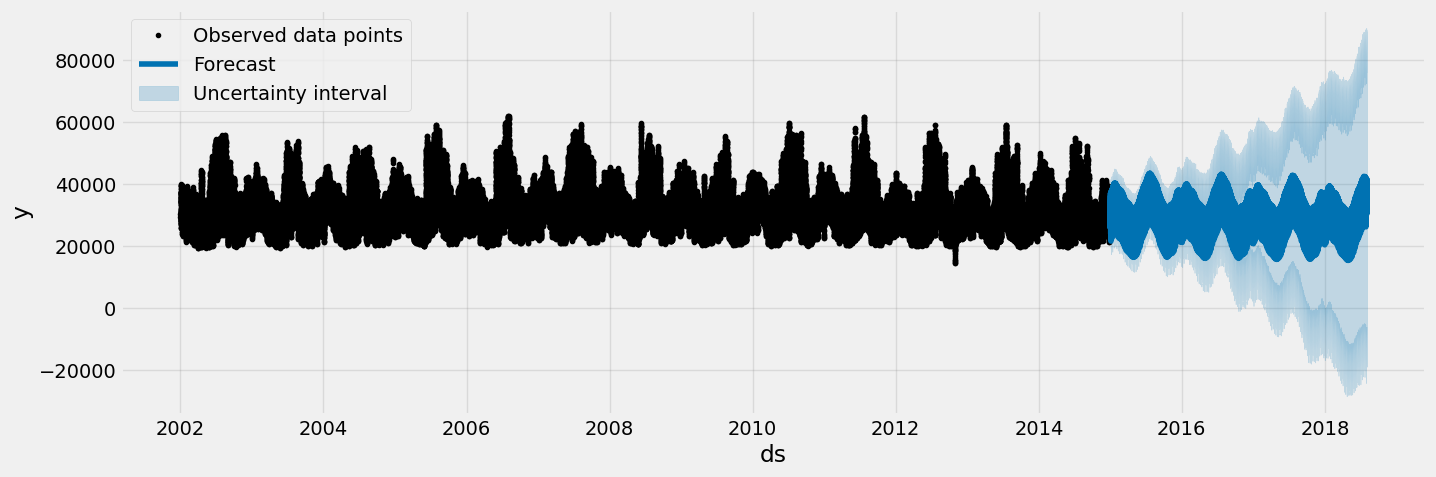

In [231]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))
pjme_test_fcst.head()

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
ax.legend()

plt.show()

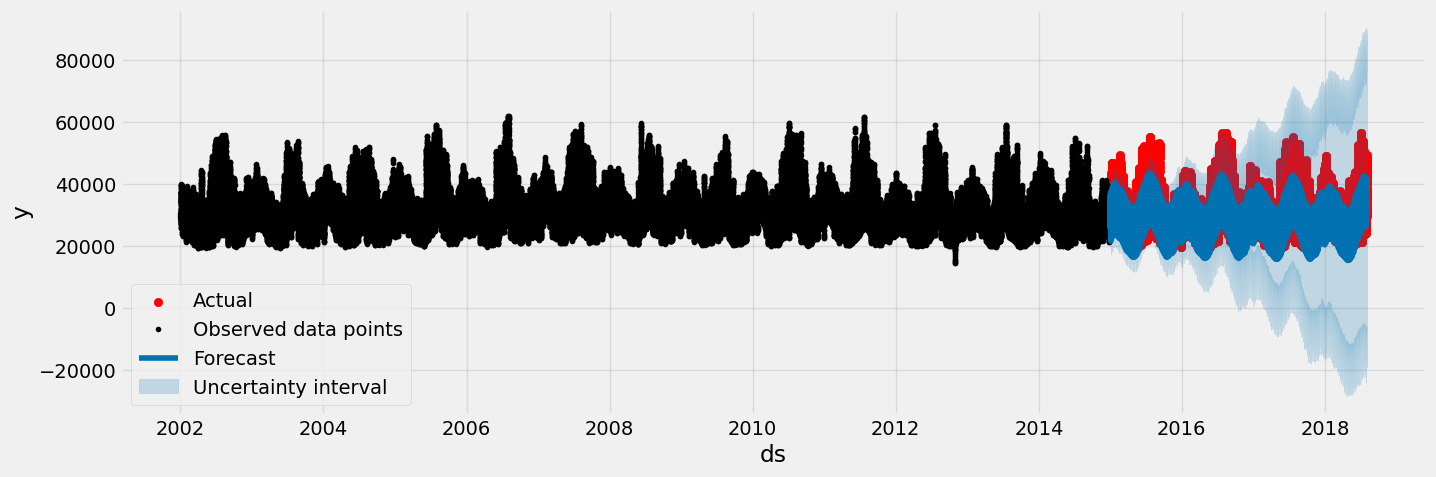

In [232]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Actual values
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r', label='Actual')

# Prophet forecast (includes forecast & trend)
fig = model.plot(pjme_test_fcst, ax=ax)

# Add legend
ax.legend()

plt.show()


In [233]:

missing_cols = [col for col in pjme_test_fcst.columns if col not in pjme_test.columns]
pjme_test = pjme_test.copy()  # To avoid modifying the original y
for col in missing_cols:
    pjme_test[col] = pjme_test_fcst[col]
pjme_test["yhat"] = pjme_test_fcst["yhat"]
# Rename yhat to MW_Prediction if you haven't yet
pjme_test_fcst = pjme_test_fcst.rename(columns={'yhat': 'MW_Prediction'})

# Assign forecast to the test set directly
pjme_test['MW_Prediction'] = pjme_test_fcst['MW_Prediction'].values
pjme_all = pd.concat([pjme_train,pjme_test], sort=False)



## Look at first month of predictions

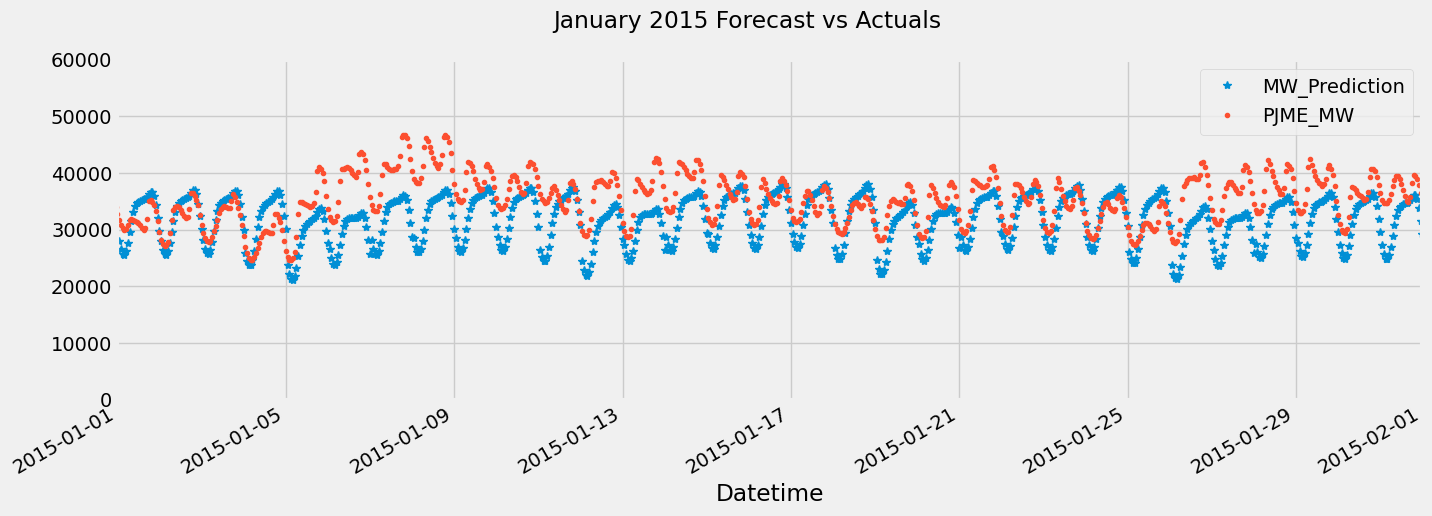

In [234]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['*','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')




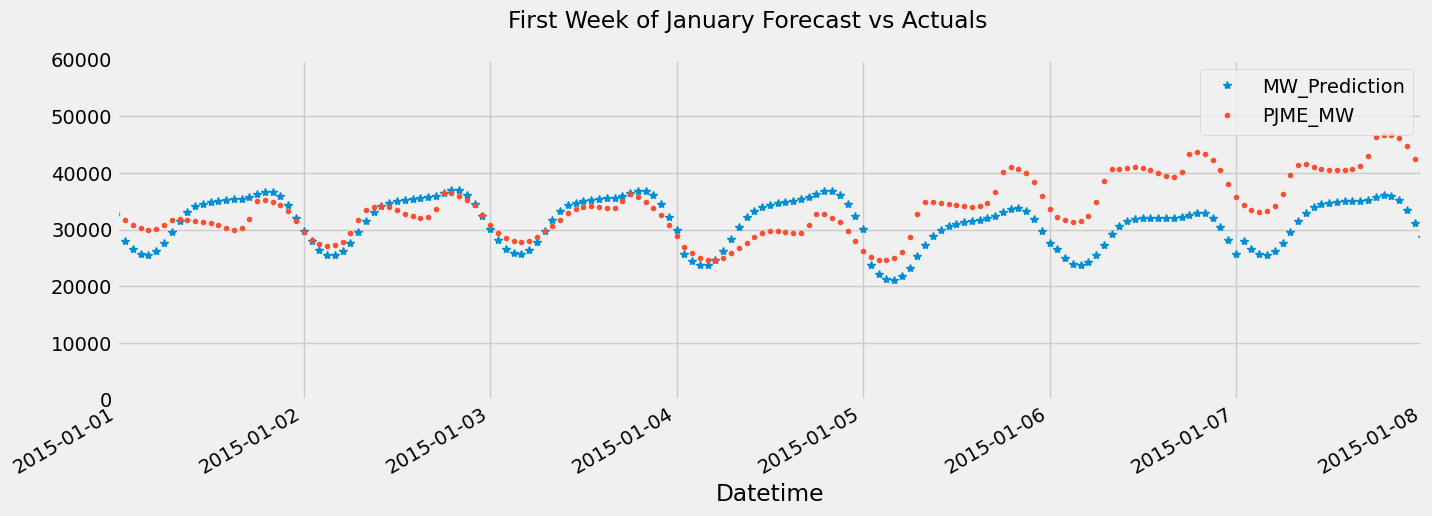

In [235]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['*','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

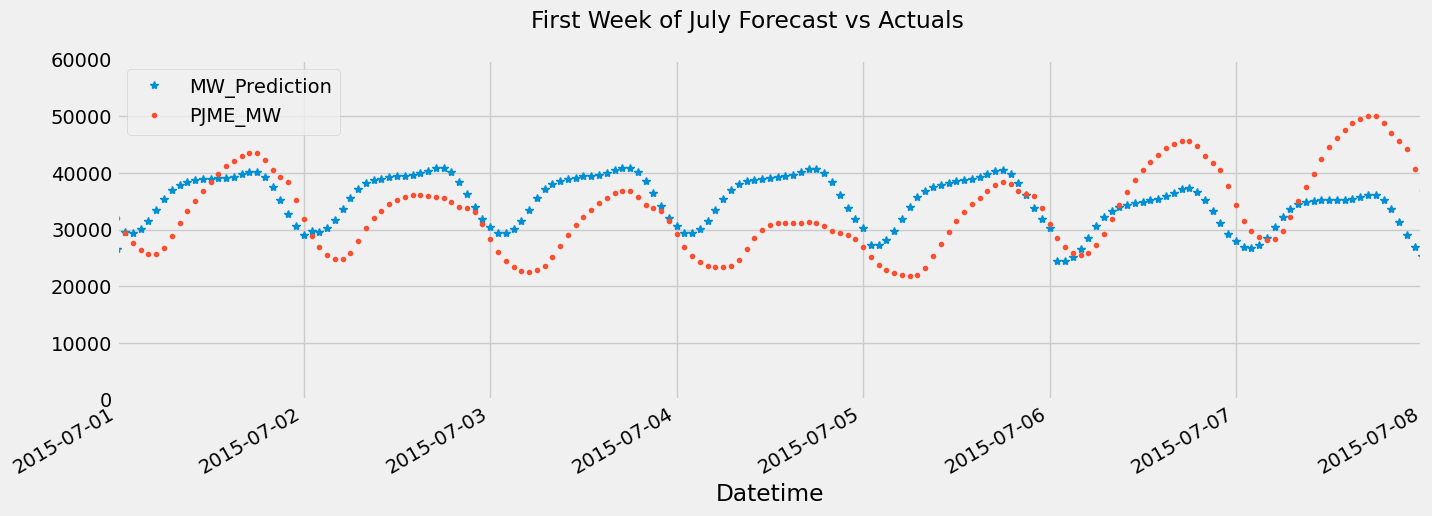

In [236]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['*','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

In [237]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

43751235.574201085

In [238]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

5181.449393612847

In [239]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [240]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

np.float64(16.50925333914033)

## Look at Worst and Best Predicted Days

In [241]:
missing_cols = [col for col in X_test.columns if col not in pjme_test.columns]
pjme_test = pjme_test.copy()  # To avoid modifying the original y
for col in missing_cols:
    pjme_test[col] = X_test[col]


In [242]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year', 'month', 'dayofmonth']).mean(numeric_only=True)[['PJME_MW', 'MW_Prediction', 'error', 'abs_error']]


In [243]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2015 5     23          23496.583333   37083.576387 -13586.993053  13586.993053
2016 5     22          23595.416667   36467.191251 -12871.774584  12871.774584
           15          23152.458333   35727.304155 -12574.845821  12574.845821
2015 5     24          24053.416667   36516.233533 -12462.816866  12462.816866
     6     7           25840.583333   38071.038699 -12230.455366  12230.455366
2016 5     8           22873.875000   34720.065468 -11846.190468  11846.190468
2017 6     3           25119.666667   36962.444789 -11842.778122  11842.778122
2015 6     6           26893.333333   38655.304862 -11761.971528  11761.971528
2016 5     21          23928.916667   35602.403509 -11673.486842  11673.486842
2017 5     27          24595.583333   36138.644806 -11543.061473  11543.061473

In [244]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     12          45724.708333   25643.338152  20081.370181  20081.370181
           11          45225.458333   25531.808299  19693.650034  19693.650034
     9     9           43836.958333   24155.481788  19681.476545  19681.476545
2015 2     16          43949.500000   25379.472408  18570.027592  18570.027592
2016 8     26          42086.083333   24315.773056  17770.310277  17770.310277
     9     8           41585.083333   23855.874846  17729.208487  17729.208487
     8     13          45185.833333   27860.239333  17325.594000  17325.594000
2015 8     17          41400.833333   25094.305007  16306.528326  16306.528326
     9     8           40713.916667   24439.597790  16274.318876  16274.318876
2016 8     14          44427.333333   28487.143677  15940.189657  15940.189657

In [245]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 12    29          29839.916667   29813.206925    26.709741   567.748318
2018 5     31          31445.000000   30678.530499   766.469501   810.458323
2017 1     3           31555.041667   30943.085256   611.956410   871.911534
2015 12    28          29250.458333   29261.782711   -11.324377   890.635499
2017 3     1           27574.125000   27907.384851  -333.259851  1024.902341
     1     17          32217.291667   32054.006550   163.285117  1051.127757
2016 10    27          28611.166667   28254.419529   356.747138  1058.875622
2018 5     16          29049.833333   29233.208045  -183.374712  1113.223827
     1     17          37451.208333   37891.936140  -440.727807  1126.014327
     7     30          32957.416667   31915.180121  1042.236546  1169.712451

## Plotting some best/worst predicted days

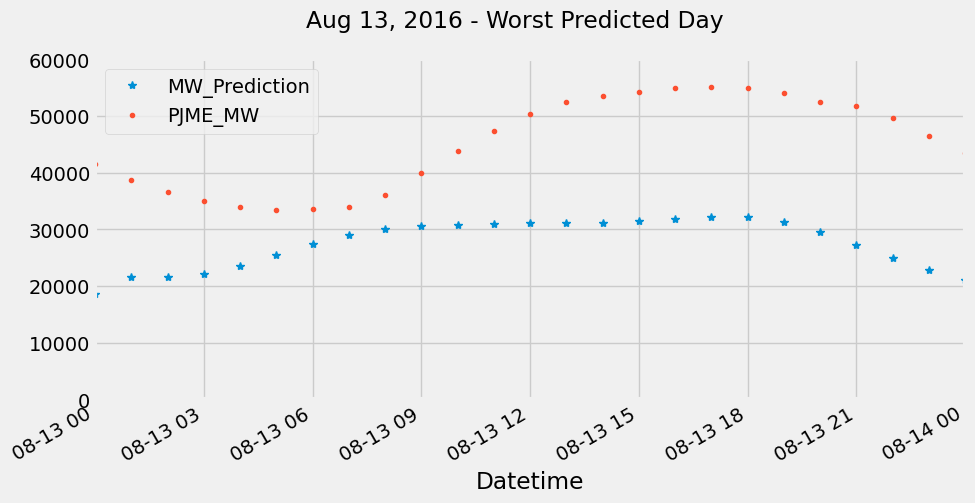

In [246]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['*','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

This one is pretty impressive. SPOT ON!

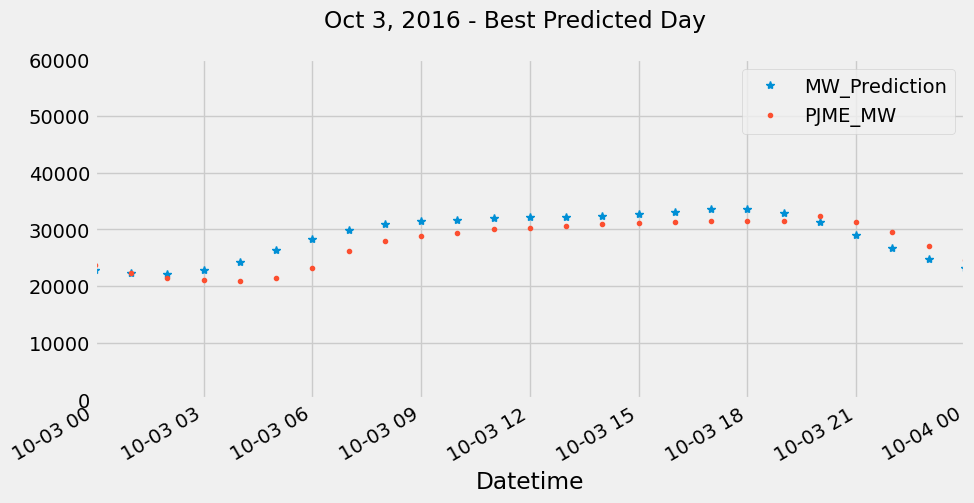

In [247]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['*','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')

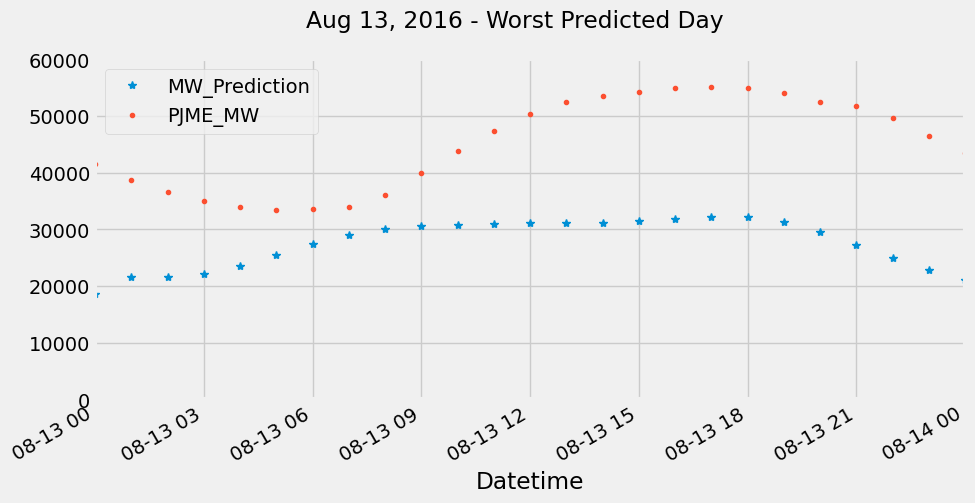

In [248]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['*','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')